In [81]:
import os
import sys
import random
import importlib
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import config # 1. 모듈 자체를 import
importlib.reload(config) # 2. 강제로 파일을 다시 읽어서 메모리 갱신
from config import Config # 3. 갱신된 모듈에서 클래스를 다시 가져옴
print("✅ Config 파일이 새로 갱신되었습니다.")

# 노트북 내에서 그래프를 바로 보기 위한 매직 커맨드
%matplotlib inline

# 시드 고정 (시각화 색상 일관성을 위해)
def set_seed(seed=21):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(21)
print("Library Loaded & Seed Set.")

✅ Config 파일이 새로 갱신되었습니다.
Library Loaded & Seed Set.


In [82]:
def decode_mask_to_colormap(mask):
    """
    (29, H, W) 형태의 마스크를 알록달록한 (H, W, 3) 이미지로 변환
    """
    H, W = mask.shape[1], mask.shape[2]
    colormap = np.zeros((H, W, 3), dtype=np.uint8)
    
    # 클래스별 고유 색상 생성
    np.random.seed(21)
    colors = [np.random.randint(50, 255, 3).tolist() for _ in range(len(Config.CLASSES))]
    
    for c in range(len(Config.CLASSES)):
        class_mask = mask[c]
        if class_mask.max() > 0:
            color = colors[c]
            # 해당 클래스 영역에 색상 입히기
            colormap[class_mask > 0.5] = color
            
    return colormap

def get_error_colormap(gt_mask, pred_mask):
    """
    정답과 예측의 차이를 시각화 (Error Analysis)
    - Red: False Negative (놓친 것)
    - Blue: False Positive (잘못 예측한 것)
    """
    # 29개 클래스를 하나로 합쳐서(Max projection) "뼈가 있냐 없냐"로 단순화하여 비교
    # (클래스가 틀린 경우까지 보려면 argmax를 써야 하지만, 여기서는 형태학적 오류에 집중)
    gt_binary = np.max(gt_mask, axis=0) > 0.5
    pred_binary = np.max(pred_mask, axis=0) > 0.5
    
    H, W = gt_binary.shape
    error_map = np.zeros((H, W, 3), dtype=np.uint8)
    
    # 1. False Negative (Miss): 정답은 있는데(True), 예측은 없다고(False) 함 -> 빨강
    fn_mask = np.logical_and(gt_binary, ~pred_binary)
    error_map[fn_mask] = [255, 0, 0] # Red
    
    # 2. False Positive (Noise): 정답은 없는데(False), 예측은 있다고(True) 함 -> 파랑
    fp_mask = np.logical_and(~gt_binary, pred_binary)
    error_map[fp_mask] = [0, 0, 255] # Blue
    
    return error_map

In [83]:
# 1. Config에 정의된 모듈 동적 로드
try:
    dataset_module = importlib.import_module(Config.DATASET_FILE)
    XRayDataset = dataset_module.XRayDataset
    get_transforms = dataset_module.get_transforms
    print(f">> Dataset Loaded from: {Config.DATASET_FILE}")
except Exception as e:
    print(f"❌ Error loading dataset module: {e}")

# 2. 모델 로드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = os.path.join(Config.SAVED_DIR, "best_model.pt")

if not os.path.exists(model_path):
    print(f"❌ Model not found at: {model_path}")
    print("  -> 학습이 완료되었는지, 경로가 맞는지 확인해주세요.")
else:
    print(f">> Loading Model from: {model_path}")
    try:
        # [수정된 부분] weights_only=False 옵션 추가!
        model = torch.load(model_path, map_location=device, weights_only=False)
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Model load failed: {e}")
        
    model.eval()

# 3. Validation 데이터셋 준비
valid_dataset = XRayDataset(is_train=False, transforms=get_transforms(is_train=False))

# 시각화를 위해 Shuffle=True로 설정
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=0)

print(f">> Validation Set Size: {len(valid_dataset)} images ready.")

>> Dataset Loaded from: dataset.dataset
>> Loading Model from: checkpoints/WJH_008_unetb2_dicetest_25e/best_model.pt
✅ Model loaded successfully!
>> Validation Set Size: 160 images ready.


🔎 ID 'ID001' 검색 성공! -> Index 0: ID001/image1661130828152_R.png
ℹ️ Normalized Image Detected -> Denormalizing...


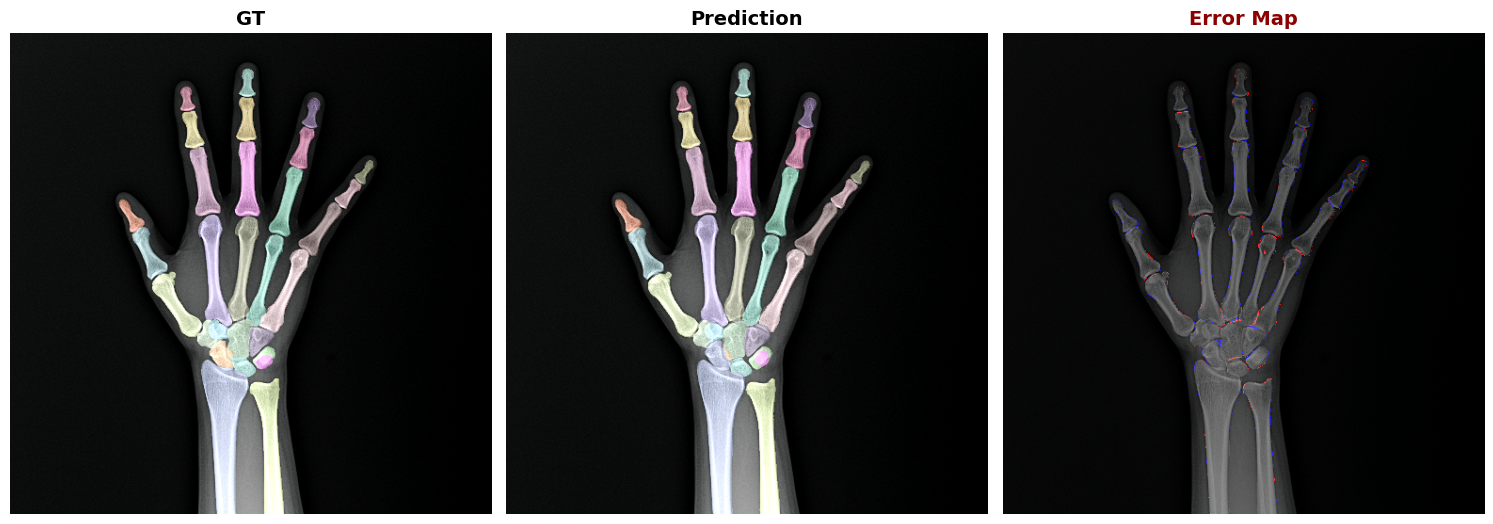

In [88]:
# ==========================================
# [사용자 설정] 보고 싶은 이미지를 지정하세요
# ==========================================
TARGET_ID = "ID001"   # 보고 싶은 ID 또는 Index (예: 10)
ALPHA = 0.4          # 투명도

# ==========================================
# [검색 로직] Dataset에서 이미지 찾기
# ==========================================
def find_data_by_target(dataset, target):
    if isinstance(target, int):
        if 0 <= target < len(dataset):
            print(f"📌 Index {target} 선택됨: {dataset.filenames[target]}")
            return dataset[target]
    elif isinstance(target, str):
        for i, fname in enumerate(dataset.filenames):
            if target in fname:
                print(f"🔎 ID '{target}' 검색 성공! -> Index {i}: {fname}")
                return dataset[i]
    
    # 못 찾으면 첫 번째 거 반환
    print(f"⚠️ '{target}'를 찾을 수 없어 첫 번째 이미지를 가져옵니다.")
    return dataset[0]

# 1. 데이터 가져오기
image, mask = find_data_by_target(valid_dataset, TARGET_ID)

# 2. 배치 차원 추가
images = image.unsqueeze(0).to(device)
masks = mask.unsqueeze(0).to(device)

# 3. 추론
with torch.no_grad():
    if device == 'cuda':
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            if isinstance(outputs, dict): outputs = outputs['out']
    else:
        outputs = model(images)
        if isinstance(outputs, dict): outputs = outputs['out']

    if outputs.shape[-2:] != masks.shape[-2:]:
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

    preds = (torch.sigmoid(outputs) > 0.5).float()

# =========================================================================
# 🚑 [핵심 수정] 이미지 역정규화 (Denormalization)
# =========================================================================
img_np = images[0].cpu().permute(1, 2, 0).numpy()

# 1. 정규화가 되어 있는지 확인 (최소값이 음수면 정규화된 것임)
if img_np.min() < 0:
    print("ℹ️ Normalized Image Detected -> Denormalizing...")
    # ImageNet Mean/Std (일반적인 경우)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # 역정규화: (img * std) + mean
    img_np = (img_np * std) + mean
    
    # 값 범위를 0~1로 클리핑 (노이즈 제거)
    img_np = np.clip(img_np, 0, 1)

# 2. 0~255 스케일로 변환
img_np = (img_np * 255).astype(np.uint8).copy()

# 3. Grayscale 처리 (RGB 변환)
if img_np.shape[2] == 1:
    img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
# =========================================================================

# (B) 마스크 및 에러맵
gt_mask_np = masks[0].cpu().numpy()
pred_mask_np = preds[0].cpu().numpy()

gt_colormap = decode_mask_to_colormap(gt_mask_np)
pred_colormap = decode_mask_to_colormap(pred_mask_np)
error_colormap = get_error_colormap(gt_mask_np, pred_mask_np)

# (C) 오버레이
gt_overlay = cv2.addWeighted(img_np, 1, gt_colormap, ALPHA, 0)
pred_overlay = cv2.addWeighted(img_np, 1, pred_colormap, ALPHA, 0)
error_overlay = cv2.addWeighted(img_np, 0.6, error_colormap, 0.9, 0)

# --- 화면 출력 ---
plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.imshow(gt_overlay)
plt.title(f"GT", fontsize=14, fontweight='bold')
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(pred_overlay)
plt.title("Prediction", fontsize=14, fontweight='bold')
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(error_overlay)
plt.title("Error Map", fontsize=14, fontweight='bold', color='darkred')
plt.axis("off")

plt.tight_layout()
plt.show()